[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/tutorials/8_nb_ensemble_learning.ipynb) 


# Predictive Analytics II

Let's first look into ways for improving the predictive power of tree-based classifiers through *ensemble learning*. Recall that an ensemble is a **collection of multiple base models**. The base models are prediction models on their own. In a homogeneous ensemble, we produce the base models with the same supervised learning algorithm whch is the focus of this tutorial. Our underlying learning algorithm will be a classification tree. 

The outline of the first part of the Notebook is as follows:
- Boosting principles
- XGBoost with xgb

In the second part we'll take a quick look at neural networks with PyTorch. We will address
- Neural Network classification with feedforward NNs

# Preliminaries
We begin as usual with importing our standard libraries and also our standard modeling data. Since we are also familiar with data organization by now, we will also use `sklearn`'s functionality to partition our data into a training and a test set. 

In [3]:
# Import standard Python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.model_selection import train_test_split
# Pretty printing
from pprint import pprint

# Some configuration of the plots we will create later
%matplotlib inline  
plt.rcParams["figure.figsize"] = (12,6)

# Load credit risk data in pre-processed format from GitHub
df = pd.read_csv('../data/hmeq_modeling.csv', index_col="index")

# Split data into target and features
pd_X = df.drop(['BAD'], axis=1) 
pd_y = df['BAD'].astype(int)  # also make the target an integer value

# no dev set this time, we will use cross-validation on the train data
X_train, X_test, y_train, y_test = train_test_split( pd_X, pd_y, test_size=0.3, random_state=42)

print("shape of the data: ")
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

shape of the data: 
(4172, 18) (4172,) (1788, 18) (1788,)


# Short Intro to Boosting
Boosting-type algorithms are based on **two core principles**:
1. Develop an ensemble sequentially (i.e. add one model at a time)
2. Let the next model in the chain correct the errors of the current ensemble

We discussed two flavors of boosting in the lecture:
- **adaboost algorithm**, first instantiation of a boosting ensemble
- **gradient boosting**, proposed in the paper [Greedy Function Approximation: A Gradient Boosting Machine](https://www.jstor.org/stable/2699986?seq=1) by Jerome H. Friedman

This part of the tutorial follows the same approach as above, we first demonstrate implementing a boosting ensemble from scratch and then showcase its use together with a professional machine learning library. Many derivatives of boosting and libraries exist. Some members of the gradient boosting family include:
- [LightGBM from Microsoft](https://lightgbm.readthedocs.io/en/latest/)
- [Catboost from Yandex](https://catboost.ai/)
- [NGBoost from Stanford ML Group](https://stanfordmlgroup.github.io/projects/ngboost/)

Given wide adoption in practice and academia, we opted for focusing the tutorial to **extreme gradient boosting** or XGB for short. Demos for other popular boosting algorithms are available via the links above. Boosting algorithms that do not follow the gradient boosting principle may be considered somewhat old-fashioned. We will not cover them here. However, the exercises give you an opportunity to implement your own Adaboost ensemble from scratch. And of course, `sklearn` also supports adaboost and other boosting algorithms.    

## Verifying the boosting principle
Is it true really true that one model can *learn* or *correct* the errors of another model as promised by the boosting paradigm? Before diving into cutting-edge gradient boosting, let's convince ourselves of this  fundamental premise of boosting. 

For this purpose, we use the HMEQ data set and demonstrate that training a model on the errors of a previous model helps to reduce classification error. Since it is common practice to implement boosting using trees as base model, we follow this approach.  

In [42]:
from sklearn import tree

### Model training 
Here we will show the effectiveness of corrective models that *train on errors*. We will first train two models, the first will be for regular predictions. The second will predict which observations the first model misclassifies. We will first run the first prediction on test data, then correct these predictions using the second model.


In [43]:
estimators = []   # List to store the two tree models

In [44]:
# Train first classifier
clf = tree.DecisionTreeClassifier(criterion="entropy", min_samples_split=2, max_depth=2)  # First classifier
dt = clf.fit(X_train, y_train)  # Fit the classifier
estimators.append(('first model', dt))

Having obtained our first model, we can calculate that model's residuals on the training set. Let's consider a classification setting. More concretely, let's focus on discrete class predictions. Recall that this is the type of output that we obtain when calling the function `predict()`.  

In [45]:
initial_pred = dt.predict(X_train)  # Classify training set using first classifier

Next, we identify misclassified observations and calculate the **classification error**.

Let's produce a binary vector with the same length as the training set in which an entry of `True` indicates that the corresponding training set observation is misclassified by our first tree. The way we design our vector also makes it very easy to compute the classification error. All we need is to find the mean of that vector.

In [46]:
res = initial_pred != y_train
print("Classification error of tree #1 is {:.4}".format(res.mean()))
print("Total number of errors tree #1 is", res.sum())

Classification error of tree #1 is 0.1496
Total number of errors tree #1 is 624


On to model #2. Here, we train not on $y$ but a new binary target variable indicating whether model #1 classified an observation correctly. We can think of this new target as $y - \hat{y}$ ie. the residual. However, since we train on decisions of a binary outcome, this classifier will predict errors of the first classifier.

In [47]:
clf2 = tree.DecisionTreeClassifier(criterion="gini")  # instantiate second model
dt_res = clf2.fit(X_train, res)                       # note the new target, we are training on residuals
estimators.append(('second model', dt_res))           # store second model for later
dt_res

DecisionTreeClassifier()

Calling the `predict`function of our second corrective model, we obtain a prediction of which observations model #1 is likely to misclassify. 

In [48]:
likely_misclassifications = dt_res.predict(X_train) 
print("Based on model #2, we expect model #1 to misclassify {} observations.".format(
    likely_misclassifications.sum()))

Based on model #2, we expect model #1 to misclassify 624 observations.


In [49]:
# Check if classified likely misclassifications are the same as residuals
accuracy_misclassifications = likely_misclassifications == res
print(accuracy_misclassifications)

index
5774    True
5098    True
5428    True
257     True
507     True
        ... 
3772    True
5191    True
5226    True
5390    True
860     True
Name: BAD, Length: 4172, dtype: bool


In [50]:
# It seems likely misclassifications are exactly congruent with residuals, so the model does work
accuracy_misclassifications.mean() 

1.0

### Model testing

Now that we have our two models, we will begin using the test data to see if a combination of the two models can reduce the value of the residuals. We will first predict y using X_test.

In [51]:
pred_initial_test = dt.predict(X_test)

In [52]:
res_test = pred_initial_test != y_test
print("Test error of model 1: {:.4}".format(res_test.mean()))

Test error of model 1: 0.1482


Now we predict for which observations model 1 has likely made an error.

In [53]:
likely_misclassifications_test = dt_res.predict(X_test)
likely_misclassifications_test

array([False, False,  True, ..., False, False, False])

Lastly, we correct the likely misclassifications by simply flipping the predicted (from model 1) class label.

In [54]:
pred_corrected = pd.Series(pred_initial_test)
pred_corrected[likely_misclassifications_test] = ~ pred_corrected[likely_misclassifications_test]

In [55]:
pred_initial_test[likely_misclassifications_test]  # Check that they have actually been changed

array([0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1])

In [56]:
pred_corrected[likely_misclassifications_test]  # all the results are opposite, so this worked!

2      -1
9      -2
12     -2
13     -2
15     -2
       ..
1745   -2
1761   -1
1768   -1
1778   -1
1781   -2
Length: 264, dtype: int64

Time for the grand final, did we reduce the test error?

In [57]:
res_corrected = np.array(pred_corrected) != y_test
print("Test error after corrected model 1 by model 2: {:.4}".format(res_corrected.mean()))

Test error after corrected model 1 by model 2: 0.2198


Hurray!!!

A lower test error indicates that our process worked. We were able to lower the error on a test set using a second model which focused on identifying misclassified cases. Let's now examine how gradient boosting relies on similar principles but is a bit more complex in execution.

## Gradient Boosting 

Gradient boosting is one specific form of boosting (using residuals recursively to increase accuracy). This process begins with an initial simple prediction which is often the mean of the target variable. After, the algorithm iteratively goes through every feature and determines which feature will best reduce this error with a single split. This is essentially a single level tree, or stump. This stump is then chosen and added to the ensemble. Next, residuals are calculated once again and the process continues for as many iterations as deemed necessary.
 
The next application of Gradient Boosting will again be a classification example. Keep in mind that Gradient Boosting can do both regression and classification!

## XGBoost with xgb library 
Different gradient boosting algorithms exist and different implementations exist of each of those. If you want to use the *original gradient boosting machine* as proposed in [Friedman's 2001 paper](https://www.jstor.org/stable/2699986?seq=1) or his [follow-up paper on stochastic gradient boosting](http://dx.doi.org/10.1016/S0167-9473(01)00065-2), we recommend using the class `sklearn.ensemble.GradientBoostingClassifier`. It offers a lot of flexibility (e.g., hyperparameters) and is[ very well documented](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html). However, for later data sets, you might want to use **extreme gradient boosting (XGB)**, which was explicitly designed for highly scalable gradient boosting. Below, we demonstrate application of XGB to our credit risk data set.

Although `sklearn` does have a version of this algorithm, it is actually common to use the `xgboost` library for training XGB models. To be precise, `sklearn` offers an implementation of XGB but it might not incorporate the latest features. As far as the use is concerned, you will not notice any differences between the `xgboost` library and `sklearn`. However, **you might need to install the `xgboost` library before moving on**.

### Tuning XGB hyperparameters
Our modeling pipeline is exactly as before in the RF example, and in general. We tune hyperparameters using grid-search and cross-validating the training data. Once we determined good hyperparameter settings, we train a XGB model with the corresponding configuration on the entire training set and obtain test set prediction, which we assess using ROC analysis. 

In [59]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

    # Setting up the grid of meta-parameters
xgb_param_grid = {
    'colsample_bytree': np.linspace(0.5, 0.9, 5),  # random subspace
    'n_estimators': [100, 200],  # ensemble size or number of gradient steps
    'max_depth': [5, 10],   # max depth of decision trees
    'learning_rate': [0.1, 0.01],  # learning rate
    }  # early stopping if no improvement after that many iterations

gs_xgb = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=xgb_param_grid, scoring='roc_auc', cv=5, verbose=0)
gs_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                  

In [60]:
from sklearn import metrics

print("Best CV AUC: %0.4f" % gs_xgb.best_score_)
print("Optimal XGB meta-parameters:")
print(gs_xgb.best_params_)

# Find test set AUC of the best XGB classifier
fp_rate, tp_rate, _ = metrics.roc_curve(y_test, gs_xgb.predict_proba(X_test)[:, 1])
print('XGB test set AUC with optimal meta-parameters: {:.4f}'.format(metrics.auc(fp_rate, tp_rate) ))

Best CV AUC: 0.9518
Optimal XGB meta-parameters:
{'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}
XGB test set AUC with optimal meta-parameters: 0.9659


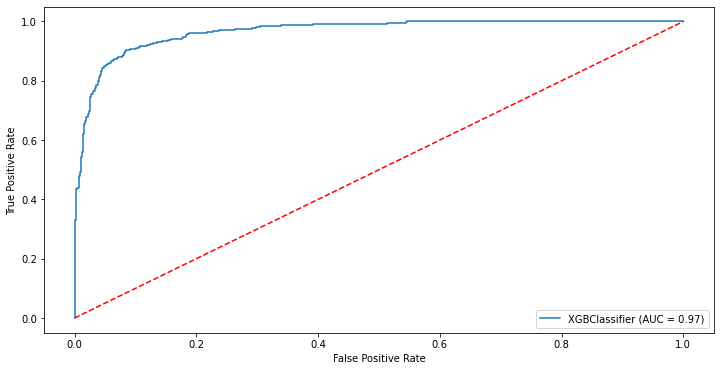

In [61]:
# The plot is not new but note the use of gs_xgb.best_estimator_ 
metrics.plot_roc_curve(gs_xgb.best_estimator_, X_test, y_test)
plt.plot([0, 1], [0, 1], "r--");

The XGB models completes our journey through the space of ensemble learning algorithms. We have now covered the maybe most important of-the-shelf machine learning algorithms and you have seen how we can apply them to real-world data. 

In future tutorials, we will go back to other steps in the machine learning pipeline and learn about yet more possibilities and procedures to derive value from data.

# A Glimpse at Neural Networks with Pytorch

A tiny intro to neural network modeling in Pytorch. Based on https://medium.com/biaslyai/pytorch-introduction-to-neural-network-feedforward-neural-network-model-e7231cff47cb and adapted to our use case.

Check the free courses on deep learning, e.g., at https://course.fast.ai/ .

Let's first look into backpropagation. You will want to revisit the section on gradient descent in the previous notebook!

In [4]:
import torch 

x = torch.ones(1, requires_grad=True)
print(x.grad)    # returns None

None


In [5]:
x = torch.ones(1, requires_grad=True)
y = x + 2
z = y * y * 2
z.backward()     # automatically calculates the gradient
print(x.grad)    # ∂z/∂x = 12

tensor([12.])


### Architectures
Pretty cool. Now let's build some architectures. This is easily done by subclassing the nn.Module class in torch. We focus on fully connected feedforward networks. The first architecture is a simple single layer perceptron-type NN. I write perceptron-type as some tiny tweaks and twists are somewhat different to the official perceptron. See https://en.wikipedia.org/wiki/Perceptron. 

The architecture itself can be seen as a hyperparameter to be tuned on a validation set! Architecture search can, however, be very tedious. In the small example below we simply fix the architectures for three versions of a fully-connected feedforward neural network.

In [6]:
# perceptron (single layer) - type classifier
class Perceptron(torch.nn.Module):
    def __init__(self, input_size):
        super(Perceptron, self).__init__()
        # linear map with weight and bias 
        self.fc = torch.nn.Linear(input_size,2)
    def forward(self, x):
        # how the data gets routed through this
        output = self.fc(x)
        return output 
# no activation here ... output goes to cross entropy loss in pytorch that does that for us!

In [7]:
# one hidden, one output layer FF
class Feedforward(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Feedforward, self).__init__()
        self.fc1 = torch.nn.Linear( input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear( hidden_size, 2)
    def forward(self, x):
        # linear map, then activation, then linear map as output
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        return output

In [8]:
# one hidden, one output layer FF
class Feedforward_deep(torch.nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3 ):
        super(Feedforward_deep, self).__init__()
        self.relu = torch.nn.ReLU()
        self.fc1 = torch.nn.Linear(input_size, hidden_size_1)
        self.fc2 = torch.nn.Linear(hidden_size_1, hidden_size_2)
        self.fc3 = torch.nn.Linear(hidden_size_2, hidden_size_3)
        self.out = torch.nn.Linear(hidden_size_3, 2)

    def forward(self, x):
        # three hidden layers with relu activation then linear output map
        # same principle as above
        hidden_1 = self.fc1(x)
        hidden_1 = self.relu(hidden_1)
        hidden_2 = self.fc2(hidden_1)
        hidden_2 = self.relu(hidden_2)
        hidden_3 = self.fc3(hidden_2)
        hidden_3 = self.relu(hidden_3)
        
        return self.out(hidden_3)

### Dataset and DataLoader Classes
Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.Dataset that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

Importantly, the dataloader will yield (shuffled) batches of data to have gradient descent operate on batches rather than single data rows! This will ultimately make gradients more stable and the learning path much smoother. 

In this context you might want to fully grasp the concept of "tensors". It is quite understandable if you think of the batch dimension added to a matrix as an example...

In [9]:
# need data loader with batch functionality
class ourdataset(torch.utils.data.Dataset):
    '''  data set class '''
    def __init__(self, df_X, df_y,  train=True):
        '''
        :param df_X: input data frame containing X 
        :param df_y: input data frame containing y
        '''
        
        df_y = df_y.to_frame()
        for k in df_X.columns:
            df_X[k] = df_X[k].astype(np.float32)
            
        # df[X_names] = df[X_names].astype(np.float32)

        for k in df_y.columns:
            # to binary for classification
            df_y[k] = (df_y[k]>0)*1
            # change data type to required type
            df_y[k] = df_y[k].astype(int)

        # set training and test data size
        self.train = train

        # train / test specs different
        self.Xs = df_X.values   #.astype(np.float32)
        self.Ys = df_y.values  #.astype(Y_name_types)

    # operator overloading for len and item
    def __len__(self):
        return self.Xs.shape[0]

    def __getitem__(self, idx):
        return ( self.Xs[idx,...],self.Ys[ [idx],...],idx ) 
    

Let's begin by filling the data loader with the training data used already in the boosting exercise...

In [10]:
# get generator instance for our train data
training_set = ourdataset(X_train, y_train)
train_batch_size = 20
drop_last_in = False
shuffle = True

train_loader = torch.utils.data.DataLoader(
        training_set, batch_size=train_batch_size, shuffle=shuffle, drop_last=drop_last_in )

/Users/axelgk/miniconda3/envs/cs330/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


The next three lines give you instances of model, loss and optimizer. Pretty important choices (and lots of alternatives available)...

In [11]:
neuralclass = Feedforward(X_train.shape[1], 5) # instantiate the model

# loss and optimizer. Note how the parameters of "neuralclass" are linked to the optimizer
criterion = torch.nn.CrossEntropyLoss()  # Note: The combination of nn.LogSoftmax and nn.NLLLoss is equivalent to using nn.CrossEntropyLoss
optimizer = torch.optim.SGD(neuralclass.parameters(), lr = 0.01)

Should have done that before: torch is build on numpy stuff so the booleans have to go. To be safe, let's quickly  transform the rest to float as well. Very inelegant code though:

In [12]:
X_test['DEROGzero'] = (X_test['DEROGzero']>0)*1  # make the boolean numeric
X_train['DEROGzero'] = (X_train['DEROGzero']>0)*1 # same
for k in X_test.columns:
    X_test[k] = X_test[k].astype(np.float32)
    X_train[k] = X_train[k].astype(np.float32)
            


/Users/axelgk/miniconda3/envs/cs330/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/axelgk/miniconda3/envs/cs330/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/axelgk/miniconda3/envs/cs330/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Now, let's do a first test run just to doublecheck. Without training, we simply feed the full test dataset and see what happens when we compute the loss. After this, we know a) we got the dimensions and loss roughly right and b) we get a test loss value we can compare the post-training losses to...

In [13]:
neuralclass.eval() # set to evaluation mode for now
y_pred = neuralclass(torch.tensor(X_test.values))   # get predictions 
before_train = criterion(y_pred.squeeze(), torch.tensor(y_test.values) )
print('Test loss before training' , before_train.item())

Test loss before training 0.592753529548645


To keep things simple(r) the training will be based on the following function. Most of the time you will want to wrap training, losses and further parameters in a more abstract class which has the model as attribute.

Revisit the definitions of epochs and batches in this context.

In [14]:
def train_this_model(model, train_loader):
    '''
    simple function to train a NN model
    inputs: model - nn.Module instance
            train_loader - nn.TrainLoader instance
    outputs: list of loss values per epoch
    '''
    model.train() # set model to training mode
    epochs = 40
    all_epoch_losses = []
    for epoch in range(epochs):

        epch_loss = 0.0  # per epoch loss

        for (XB, yB, idxsB) in train_loader:

            optimizer.zero_grad()
            # Forward pass
            y_pred = model(XB)
            # Compute Loss
            loss = criterion(y_pred, yB.squeeze())

            # Backward pass
            loss.backward()
            optimizer.step()

            # add up mini batch losses
            epch_loss += loss.item() / len(train_loader)

        print('Epoch {}: train loss: {}'.format(epoch, epch_loss) )
        all_epoch_losses.append( epch_loss  )
    
    return all_epoch_losses


all_epoch_losses__NNclass = train_this_model(neuralclass, train_loader)

Epoch 0: train loss: 0.514261830794184
Epoch 1: train loss: 0.47889554579007004
Epoch 2: train loss: 0.46837247245049374
Epoch 3: train loss: 0.4593917686830868
Epoch 4: train loss: 0.45073084725717616
Epoch 5: train loss: 0.44165136126810295
Epoch 6: train loss: 0.43359122985002524
Epoch 7: train loss: 0.42634154606663993
Epoch 8: train loss: 0.4198739373227627
Epoch 9: train loss: 0.4139487809684287
Epoch 10: train loss: 0.4083899337994424
Epoch 11: train loss: 0.4029192570864299
Epoch 12: train loss: 0.3986485490673464
Epoch 13: train loss: 0.3946206977492883
Epoch 14: train loss: 0.39051084601850594
Epoch 15: train loss: 0.386952614171083
Epoch 16: train loss: 0.3840416783208483
Epoch 17: train loss: 0.38217018159667865
Epoch 18: train loss: 0.37908681057856985
Epoch 19: train loss: 0.3775225949415747
Epoch 20: train loss: 0.37525373825616226
Epoch 21: train loss: 0.37433345879664265
Epoch 22: train loss: 0.373218869799347
Epoch 23: train loss: 0.37201497753698864
Epoch 24: train l

Now, let's apply this to the perceptron...

In [15]:
# train the perceptron-type classifier
perc = Perceptron(X_train.shape[1])
perc.eval() # set the Percept. to evaluation mode
# as before: loss and optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(perc.parameters(), lr = 0.01)

all_epoch_losses__perc = train_this_model(perc, train_loader)

Epoch 0: train loss: 0.5183417534714111
Epoch 1: train loss: 0.43553750915675643
Epoch 2: train loss: 0.4225128951825592
Epoch 3: train loss: 0.41669589074319613
Epoch 4: train loss: 0.41119780494835945
Epoch 5: train loss: 0.4081406298507917
Epoch 6: train loss: 0.4054538307435202
Epoch 7: train loss: 0.40298004512581515
Epoch 8: train loss: 0.4002738354736537
Epoch 9: train loss: 0.39852340747579995
Epoch 10: train loss: 0.3968473265045566
Epoch 11: train loss: 0.3954665014547026
Epoch 12: train loss: 0.39462729354509324
Epoch 13: train loss: 0.3930245024022871
Epoch 14: train loss: 0.39218589970084416
Epoch 15: train loss: 0.39175141035940103
Epoch 16: train loss: 0.39058525625028107
Epoch 17: train loss: 0.3895657072155672
Epoch 18: train loss: 0.3891801662992633
Epoch 19: train loss: 0.3881418862553875
Epoch 20: train loss: 0.3877493717025911
Epoch 21: train loss: 0.3873571133214322
Epoch 22: train loss: 0.38683893927261603
Epoch 23: train loss: 0.38643257612246645
Epoch 24: train

...followed by the deeper fc feedforward...

In [16]:
neuralclass_deep = Feedforward_deep(X_train.shape[1],10, 5,3)
neuralclass_deep.train()
# The combination of nn.LogSoftmax and nn.NLLLoss is equivalent to using nn.CrossEntropyLoss
criterion = torch.nn.CrossEntropyLoss()  # sigmoid already in loss
optimizer = torch.optim.SGD(neuralclass_deep.parameters(), lr = 0.01)

all_epoch_losses__NNclass_deep = train_this_model(neuralclass_deep, train_loader)

Epoch 0: train loss: 0.5479396786986354
Epoch 1: train loss: 0.48785804475893824
Epoch 2: train loss: 0.4845015569166701
Epoch 3: train loss: 0.4825675881793053
Epoch 4: train loss: 0.4806990878718891
Epoch 5: train loss: 0.47873048327471107
Epoch 6: train loss: 0.4755941757032173
Epoch 7: train loss: 0.47095678539937785
Epoch 8: train loss: 0.4639694848271648
Epoch 9: train loss: 0.4559487646276299
Epoch 10: train loss: 0.4481353947990818
Epoch 11: train loss: 0.44044233102832697
Epoch 12: train loss: 0.4334594204522776
Epoch 13: train loss: 0.426520659164949
Epoch 14: train loss: 0.4201115948018844
Epoch 15: train loss: 0.41331316202736357
Epoch 16: train loss: 0.40710866059127626
Epoch 17: train loss: 0.40091972245554025
Epoch 18: train loss: 0.3946614041924477
Epoch 19: train loss: 0.38983039593582525
Epoch 20: train loss: 0.38520532411536546
Epoch 21: train loss: 0.3812747326051219
Epoch 22: train loss: 0.37852052592061924
Epoch 23: train loss: 0.3753975142845127
Epoch 24: train l

Although this can be done more elegantly in torch itself, let's put sklearn's metrics to use again. We simply have to get the predictions from the network. Note how this is somewhat more involved in pytorch for our particular choice of loss and architecture... another reason for writing a more general class structure that behaves like the sklearn methods we have come to appreciate (.fit, .predict, etc.)

In [17]:
from sklearn import metrics 

# the perceptron
perc.eval() # set model to evaluation mode / do not train any more
y_pred = perc(torch.tensor(X_test.values))
_, y_pred = torch.max(y_pred.data, 1)  
y_pred = y_pred.detach().numpy()

# just to check:
print(np.mean(y_pred))
print('accuracy percep. class: '+  str(metrics.accuracy_score(y_pred,y_test)) )
print('balanced accuracy percep. class: '+  str(metrics.balanced_accuracy_score(y_pred,y_test)) )
print('F1 score percep. class: '+  str(metrics.f1_score(y_pred,y_test) ))


0.09731543624161074
accuracy percep. class: 0.8048098434004475
balanced accuracy percep. class: 0.7329295389479982
F1 score percep. class: 0.39092495636998253


In [18]:
neuralclass.eval() # set model to evaluation mode / do not train any more
y_pred = neuralclass(torch.tensor(X_test.values))
_, y_pred = torch.max(y_pred.data, 1)  
y_pred = y_pred.detach().numpy()

# just to check:
print(np.mean(y_pred))
print('accuracy NN class: '+  str(metrics.accuracy_score(y_pred,y_test)) )
print('balanced accuracy NN class: '+  str(metrics.balanced_accuracy_score(y_pred,y_test)) )
print('F1 score NN class: '+  str(metrics.f1_score(y_pred,y_test) ))

0.12472035794183445
accuracy NN class: 0.8165548098434005
balanced accuracy NN class: 0.7490852304474276
F1 score NN class: 0.4726688102893891


In [19]:
neuralclass_deep.eval() # set model to evaluation mode / do not train any more
y_pred = neuralclass_deep(torch.tensor(X_test.values))
_, y_pred = torch.max(y_pred.data, 1)  
y_pred = y_pred.detach().numpy()

# just to check:
print(np.mean(y_pred))
print('accuracy NN class (deep): '+  str(metrics.accuracy_score(y_pred,y_test)) )
print('balanced accuracy NN class (deep): '+  str(metrics.balanced_accuracy_score(y_pred,y_test)) )
print('F1 score NN class (deep): '+  str(metrics.f1_score(y_pred,y_test) ))

0.13366890380313198
accuracy NN class (deep): 0.8187919463087249
balanced accuracy NN class (deep): 0.7503369699981902
F1 score NN class (deep): 0.4921630094043886


Let's revisit the boosting example and compare to the NNs:

In [186]:
boost_pred = gs_xgb.best_estimator_.predict( X_test )

In [187]:
print('accuracy: '+  str(metrics.accuracy_score(boost_pred,y_test)) )
print('balanced accuracy: '+  str(metrics.balanced_accuracy_score(boost_pred,y_test)) )
print('F1 score: '+  str(metrics.f1_score(boost_pred,y_test) ))

accuracy: 0.9121923937360179
balanced accuracy: 0.9045366795366796
F1 score: 0.7779349363507779


It's also good practice (mandatory even) to look at the loss over time. This should be done with tensorboard (that's a strength of tensorflow over pytorch). For now, let's use plain vanilla matplotlib plots:

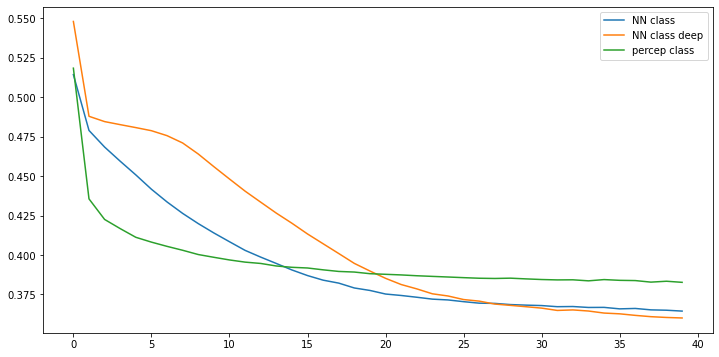

In [20]:
plt.plot( np.array(range(0,len(all_epoch_losses__NNclass))), all_epoch_losses__NNclass, label = 'NN class');
plt.plot( np.array(range(0,len(all_epoch_losses__NNclass_deep))), all_epoch_losses__NNclass_deep, label = 'NN class deep');
plt.plot( np.array(range(0,len(all_epoch_losses__perc))), all_epoch_losses__perc, label = 'percep class');
plt.legend()